In [59]:
import sys
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py
import numpy as np
import matplotlib.pyplot as plt

def read_hdf5(filename, component = "vorticity", levelNumber = 1, showDomain = False):
    if os.path.isfile(filename):
        with h5py.File(filename, 'r', locking=False) as hdf:
            # List all groups
            print("Keys in the file:")
            print(list(hdf.keys()))
        hf_in = h5py.File(filename,"r", locking=False)
        root = hf_in["/"]
        level = hf_in["level_" + str(levelNumber)]
        print(f'level attributes: {level.attrs.keys()}')
        prob_domain = level.attrs["prob_domain"]
        print(f'problem domain: {prob_domain}')
        time = level.attrs["time"]
        dx = level.attrs["dx"]
        data = hf_in["level_"+str(levelNumber)+"/data:datatype=0"]
        print(f'data dimension: {data.shape}')
        offsets = hf_in["level_" + str(levelNumber) + "/data:offsets=0"]
        attributes = hf_in["level_" + str(levelNumber) + "/data_attributes/"]
        boxes = hf_in["level_" + str(levelNumber) + "/boxes"]
        print(f'boxes: {boxes}')
        print(f'offsets: {offsets}')
        comps = attributes.attrs["comps"]
        print(f'comps: {comps}')
        components = [i.decode('utf-8') if isinstance(i, np.bytes_) else '' for i in list(root.attrs.values())]
        print(f'components: {components}')
        index = components.index(component)
        print(f'index of component: {component} is {index}')       
        print(f'boxes.shape: {boxes.shape}')

        edges = [
            (0,1), (1,2), (2,3), (3,0),
            (4,5), (5,6), (6,7), (7,4),
            (0,4), (1,5), (2,6), (3,7)
        ]
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111, projection='3d')

        # plot domain boundary 
        x1 = prob_domain[0] * dx
        x2 = prob_domain[3] * dx
        y1 = prob_domain[1] * dx
        y2 = prob_domain[4] * dx
        z1 = prob_domain[2] * dx
        z2 = prob_domain[5] * dx

        xMin = min(x1,x2)
        xMax = max(x1,x2)
        yMin = min(y1,y2)
        yMax = max(y1,y2)
        zMin = min(z1,z2)
        zMax = max(z1,z2)

        # Define cube corners
        corners = [
            [xMin,yMin,zMin], [xMax,yMin,zMin], [xMax,yMax,zMin], [xMin,yMax,zMin], 
            [xMin,yMin,zMax], [xMax,yMin,zMax], [xMax,yMax,zMax], [xMin,yMax,zMax] 
        ]

        if showDomain:
            for e in edges:
                ax.plot3D(*zip(*[corners[e[0]], corners[e[1]]]), color="k")

        minValues = []
        maxValues = []

        for box in range(boxes.shape[0]):
            data_1d = data[offsets[box]:offsets[box+1]]           
            if data_1d.shape[0] % comps != 0:
                raise ValueError(f"{data_1d.shape[0]} is not evenly divisible by {comps}.")
            data_2d = data_1d.reshape(comps, int(data_1d.shape[0]/comps))
            volume_1d = data_2d[index]
            volume_3d = volume_1d.reshape((boxes[box][3]-boxes[box][0]+1, boxes[box][4]-boxes[box][1]+1, boxes[box][5]-boxes[box][2]+1))
            minValues.append(np.min(volume_3d))
            maxValues.append(np.max(volume_3d))
            x1 = boxes[box][0] * dx
            x2 = boxes[box][3] * dx
            y1 = boxes[box][1] * dx
            y2 = boxes[box][4] * dx
            z1 = boxes[box][2] * dx
            z2 = boxes[box][5] * dx
            xMin = min(x1,x2)
            xMax = max(x1,x2)
            yMin = min(y1,y2)
            yMax = max(y1,y2)
            zMin = min(z1,z2)
            zMax = max(z1,z2)
            corners = [
                [xMin,yMin,zMin], [xMax,yMin,zMin], [xMax,yMax,zMin], [xMin,yMax,zMin], 
                [xMin,yMin,zMax], [xMax,yMin,zMax], [xMax,yMax,zMax], [xMin,yMax,zMax] 
            ]
            for e in edges:
                ax.plot3D(*zip(*[corners[e[0]], corners[e[1]]]), color="k")

            #break
            
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f"{filename}: level {levelNumber} boxes")
        plt.show()
        return minValues, maxValues
    else:
        print(filename," not found")
        return None, None

Keys in the file:
['Chombo_global', 'level_0', 'level_1', 'level_2', 'level_3']
level attributes: <KeysViewHDF5 ['dt', 'dx', 'prob_domain', 'ref_ratio', 'time']>
problem domain: (0, 0, 0, 4095, 2047, 2047)
data dimension: (160264192,)
boxes: <HDF5 dataset "boxes": shape (590,), type "|V28">
offsets: <HDF5 dataset "data:offsets=0": shape (591,), type "<i8">
comps: 22
components: ['velocity0', 'velocity1', 'fraction-0', 'boundaryArea-0', 'xAreafractionLo-0', 'xAreafractionHi-0', 'yAreafractionLo-0', 'yAreafractionHi-0', 'zAreafractionLo-0', 'zAreafractionHi-0', 'xnormal-0', 'ynormal-0', 'velocity2', 'znormal-0', 'distance-0', 'gradPres0', 'gradPres1', 'gradPres2', 'pressure', 'vorticity0', 'vorticity1', 'vorticity2', 'VanillaAMRFileType', '', '']
index of component: velocity0 is 0
boxes.shape: (590,)


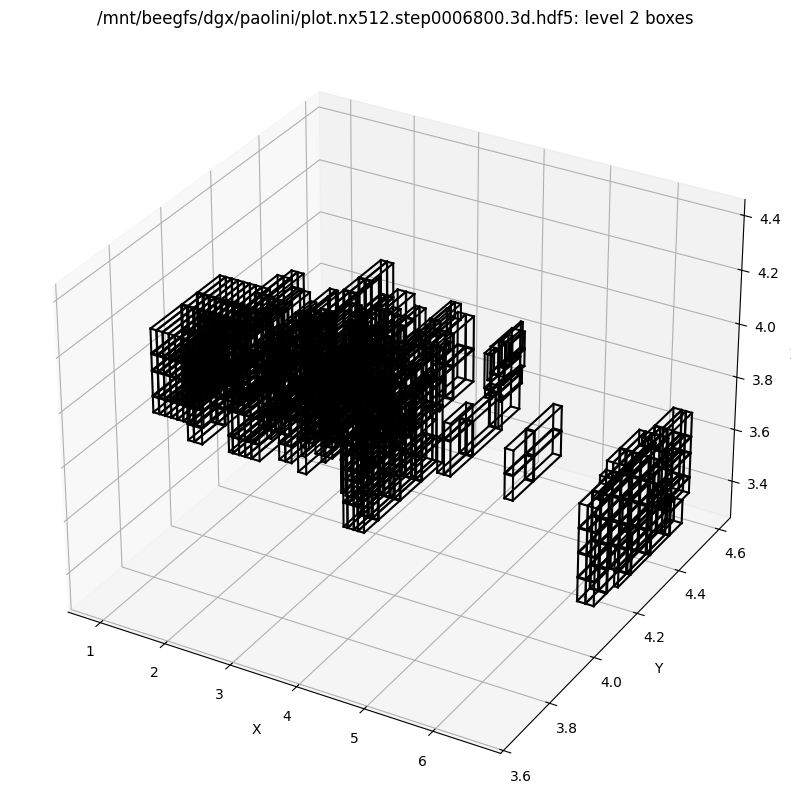

In [60]:
filename = '/mnt/beegfs/dgx/paolini/plot.nx512.step0006800.3d.hdf5'
component = "velocity0"
levelNumber = 2
minValues, maxValues = read_hdf5(filename, component, levelNumber)

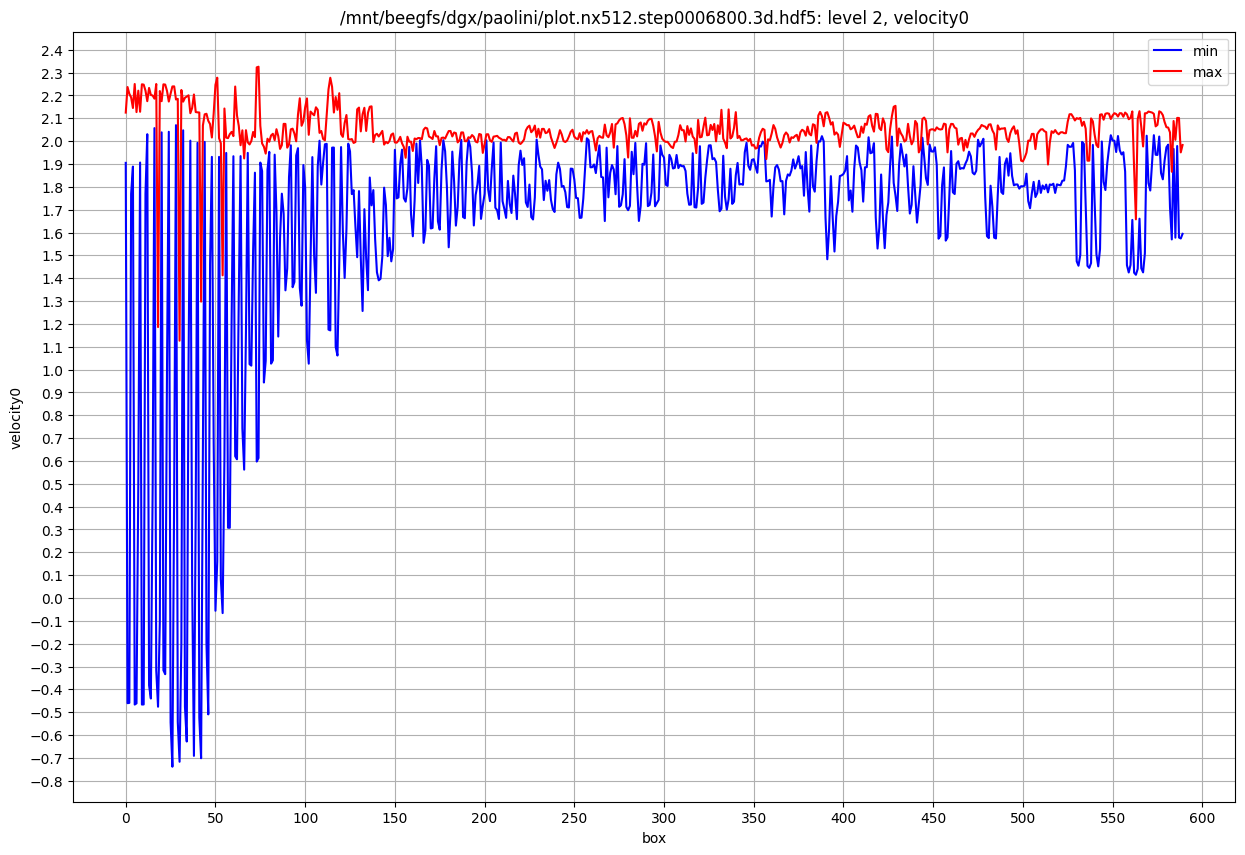

In [61]:
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
plt.plot(range(0,len(minValues)), minValues, linestyle='-', color='b', label='min')
plt.plot(range(0,len(maxValues)), maxValues, linestyle='-', color='r', label='max')
ax.set_xlabel('box')
ax.set_ylabel(component)
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # up to 15 ticks on x-axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=40))  # up to 10 ticks on y-axis
ax.set_title(f"{filename}: level {levelNumber}, {component}")
plt.grid(True)
plt.legend()
